Stratégie Bollinger Trend v2 (bande de Bollinger + moyenne mobile court et long terme)<br>
SEG

In [1]:
# Modules standards
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../..')
# Modules perso
from backtest.single_coin.bol_trend.class_boltrend.boltrendv2 import BolTrend
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation

In [2]:
# Stratégie Bollinger Trend v2 - Backtest
class BolTrend():
    def __init__(
        self,
        df,
        type=["long"],
        bol_window = 100,
        bol_std = 2.25,
        min_bol_spread = 0,
        long_ma_window = 500,
        short_ma_window = 100,
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.bol_window = bol_window
        self.bol_std = bol_std
        self.min_bol_spread = min_bol_spread
        self.long_ma_window = long_ma_window
        self.short_ma_window = short_ma_window

        
    def populate_indicators(self):
        # -- Clear dataset --
        # Les colonnes du jeu de données qui ne sont pas "open", "high", "low", "close" ou "volume" sont supprimées
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=int(self.bol_window), window_dev=int(self.bol_std))
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()

        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=int(self.long_ma_window))
        df['short_ma'] = ta.trend.sma_indicator(close=df['close'], window=int(self.short_ma_window))

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['short_ma']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['short_ma']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1, maker_fee=0.0002, taker_fee=0.0007):
        df = self.df[:]
        wallet = initial_wallet
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       
        

In [3]:
# Choix de la paire à trader et du temps des bougies
pair = "ETH/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../../database/"
)

╒═════════════════════════════╤════════════════════════════════════════════════════════╕
│ Résultats backtest          │                                                        │
╞═════════════════════════════╪════════════════════════════════════════════════════════╡
│ Période                     │ 2018-01-01 -> 2023-01-19                               │
│ Portefeuille initial        │ 1,000.00 $                                             │
│                             │                                                        │
│ Portefeuille final          │ 522,680.07 $                                           │
│ Performance vs US dollar    │ 52,168.01 %                                            │
│ Pire Drawdown T|D           │ -33.15% | -38.02%                                      │
│ Buy and hold performance    │ 108.39 %                                               │
│ Performance vs buy and hold │ 24,982.27 %                                            │
│ Nombre total de tra

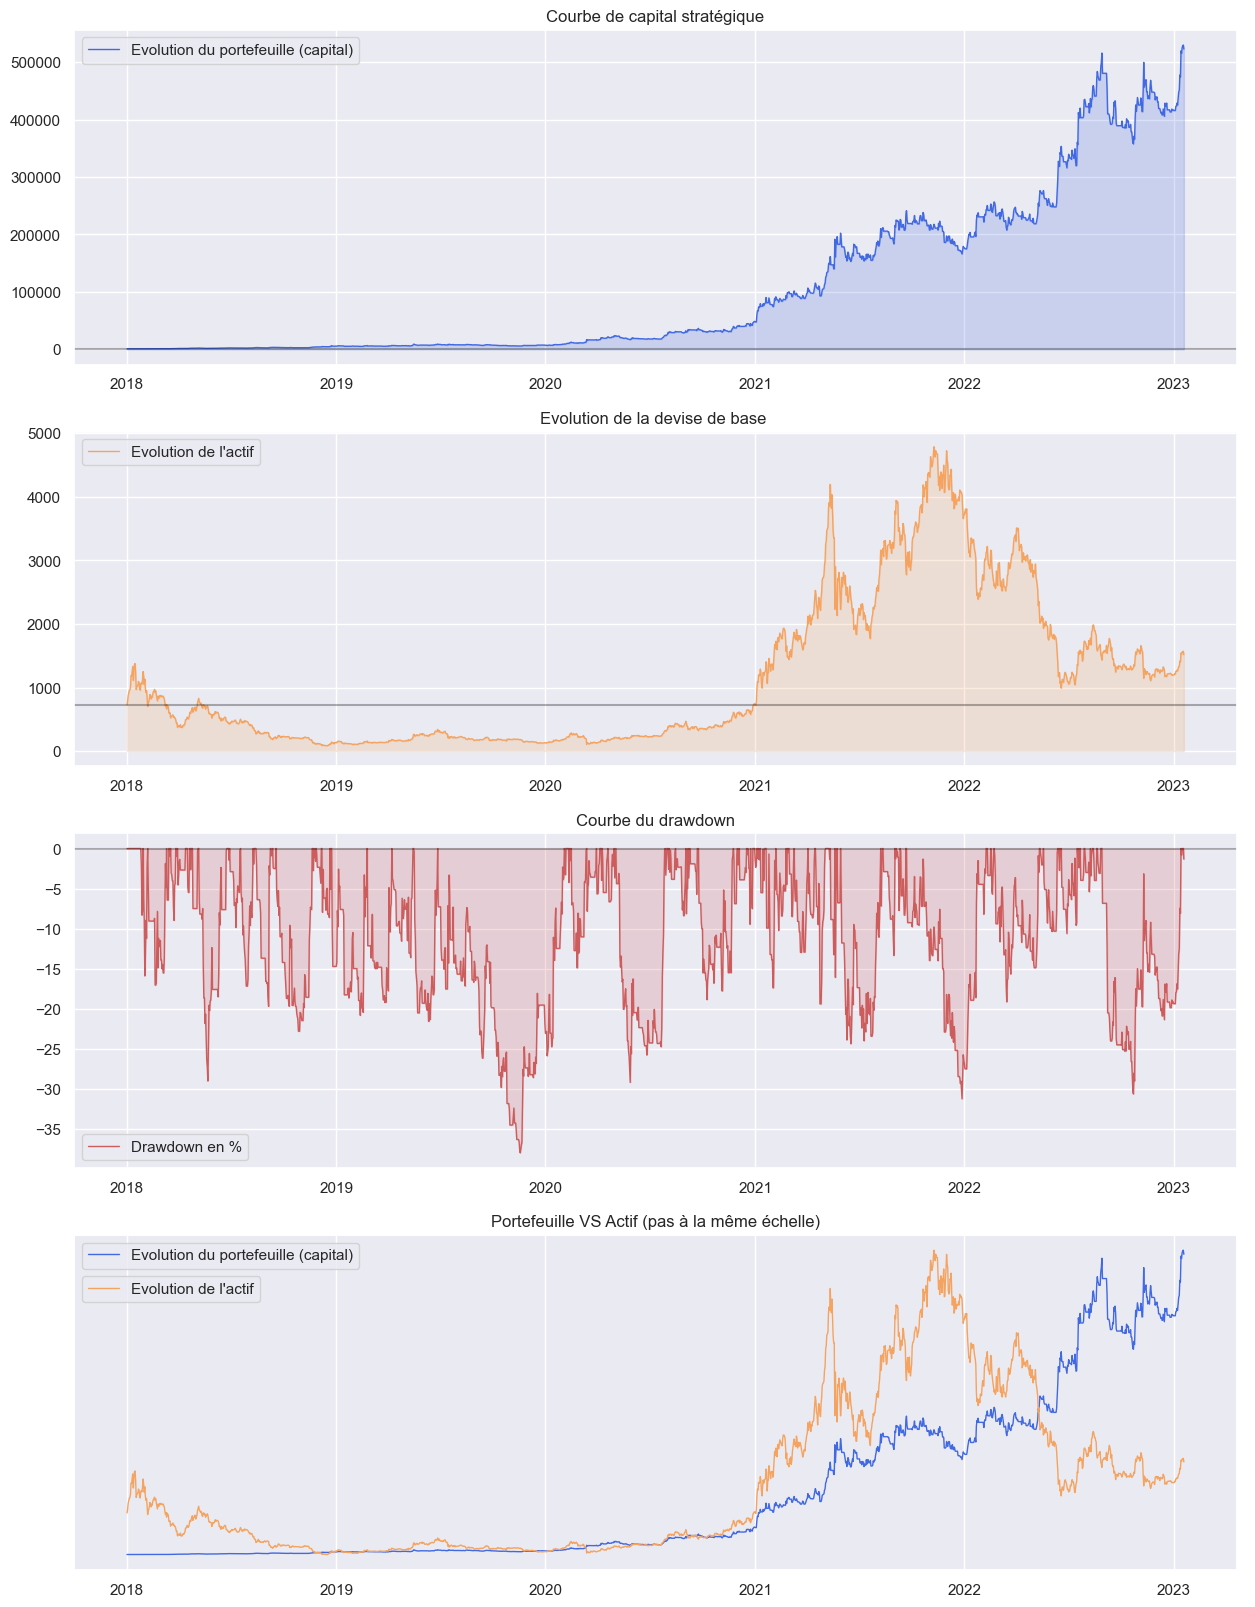

In [64]:
# Paramètres à modifier pour tester la stratégie
strat = BolTrend(
    df = df.loc["2018":],
    type=["long","short"],
    bol_window = 70,
    bol_std = 2,
    min_bol_spread = 0,
    long_ma_window = 550,   # Sens du trade
    short_ma_window = 110,  # Cloture du trade
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

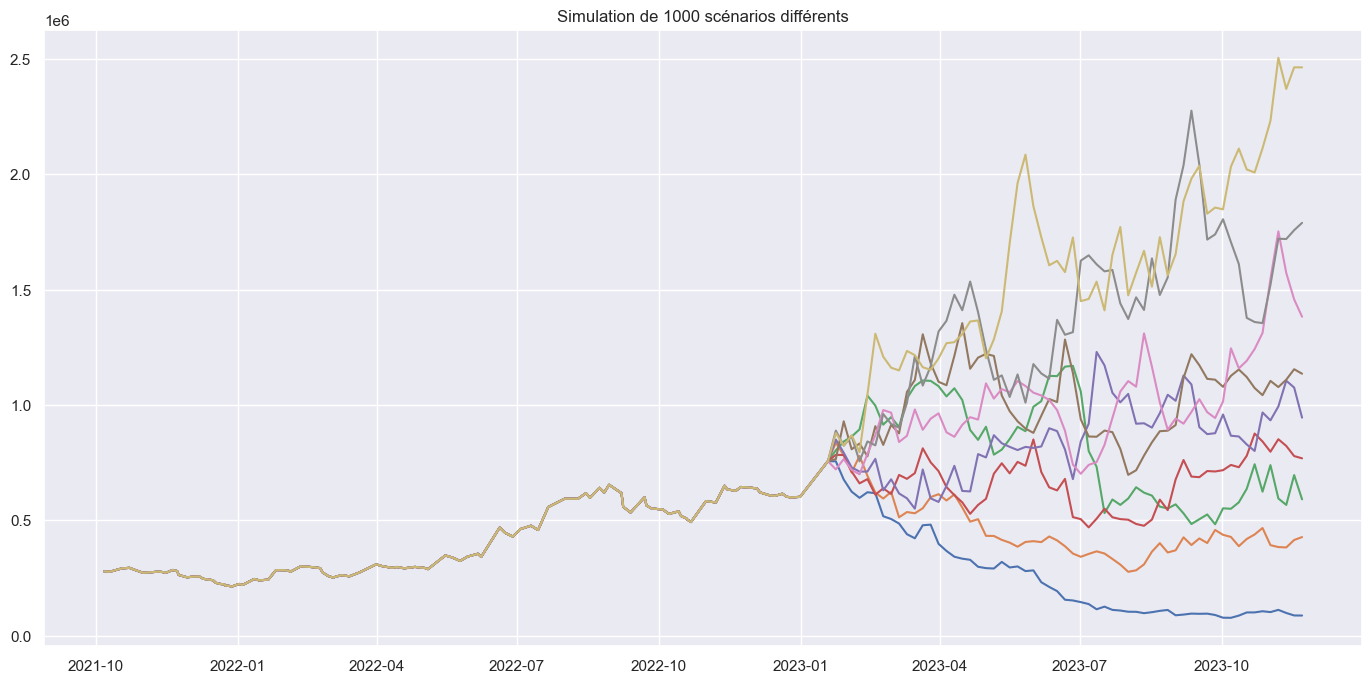

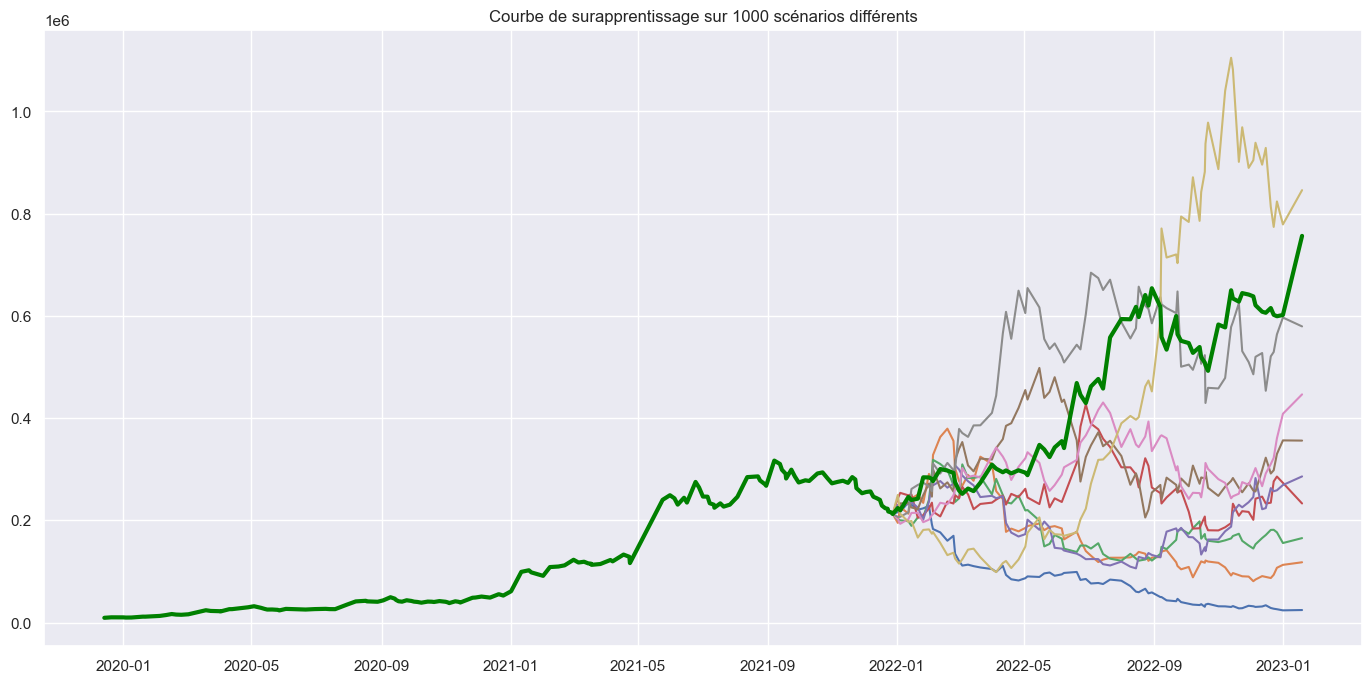

In [63]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=False
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-01-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

----- 2017 Performances cumulées: -30.07% --


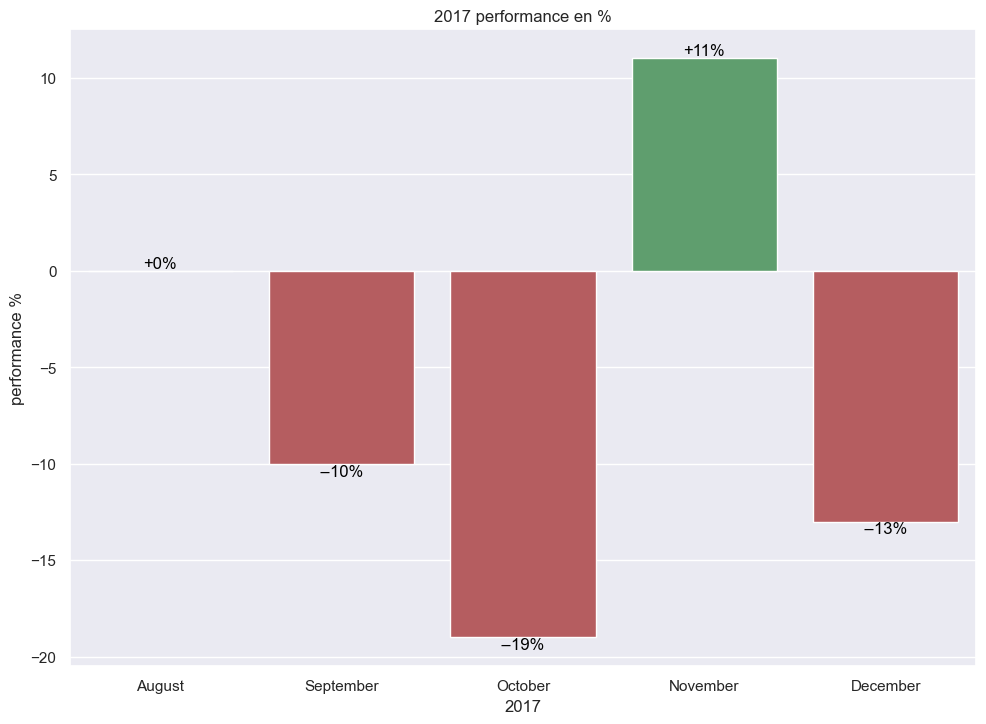

----- 2018 Performances cumulées: 578.81% --


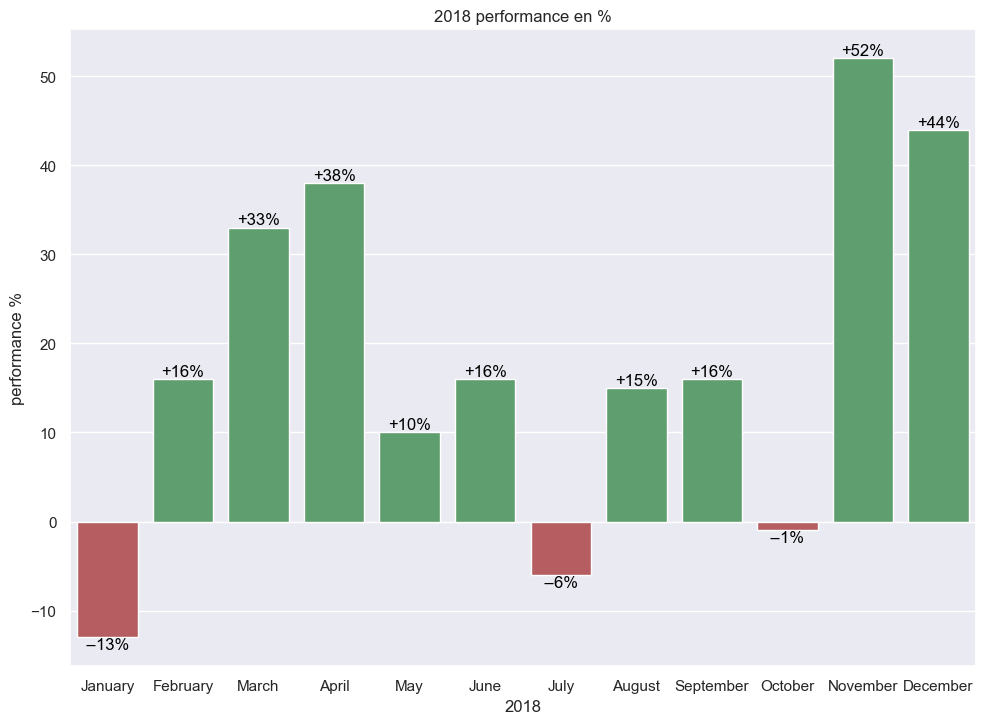

----- 2019 Performances cumulées: 104.22% --


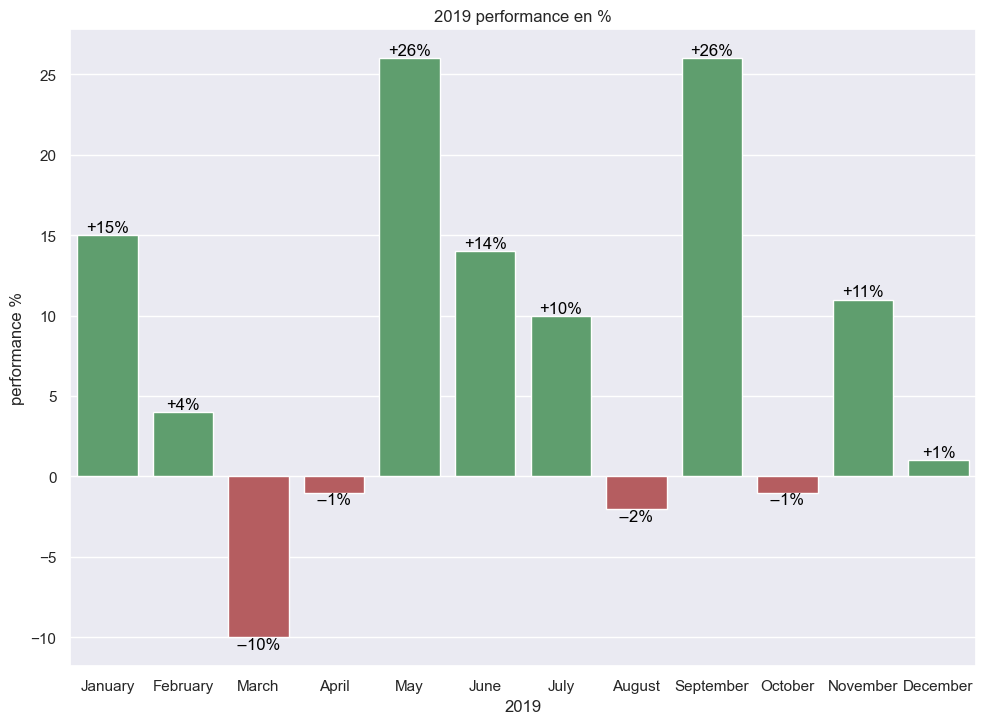

----- 2020 Performances cumulées: 297.79% --


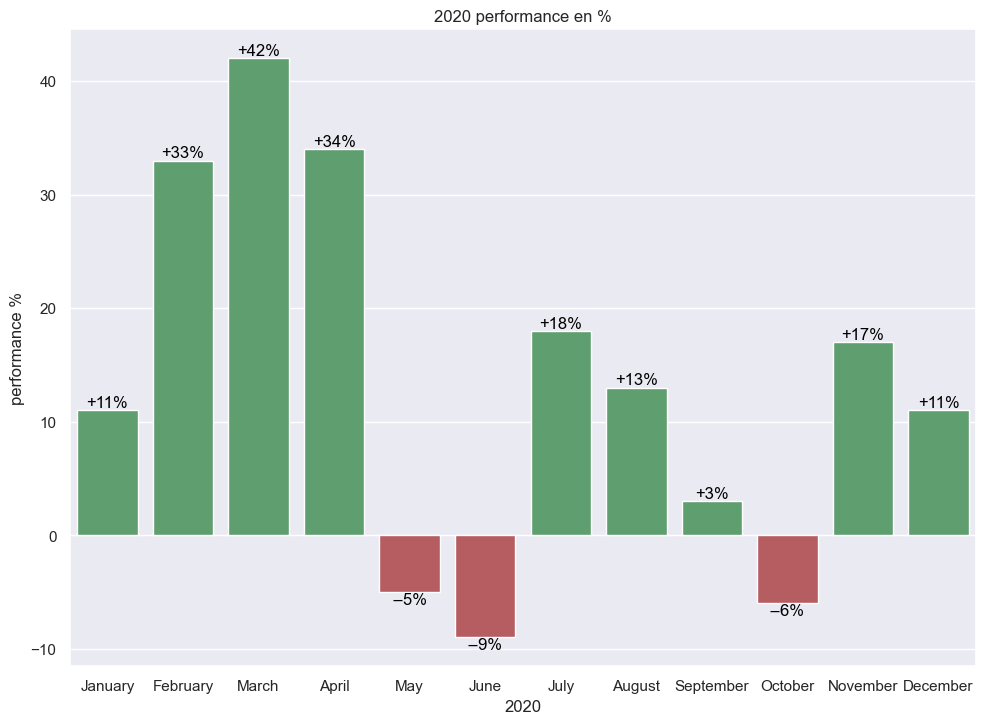

----- 2021 Performances cumulées: 336.9% --


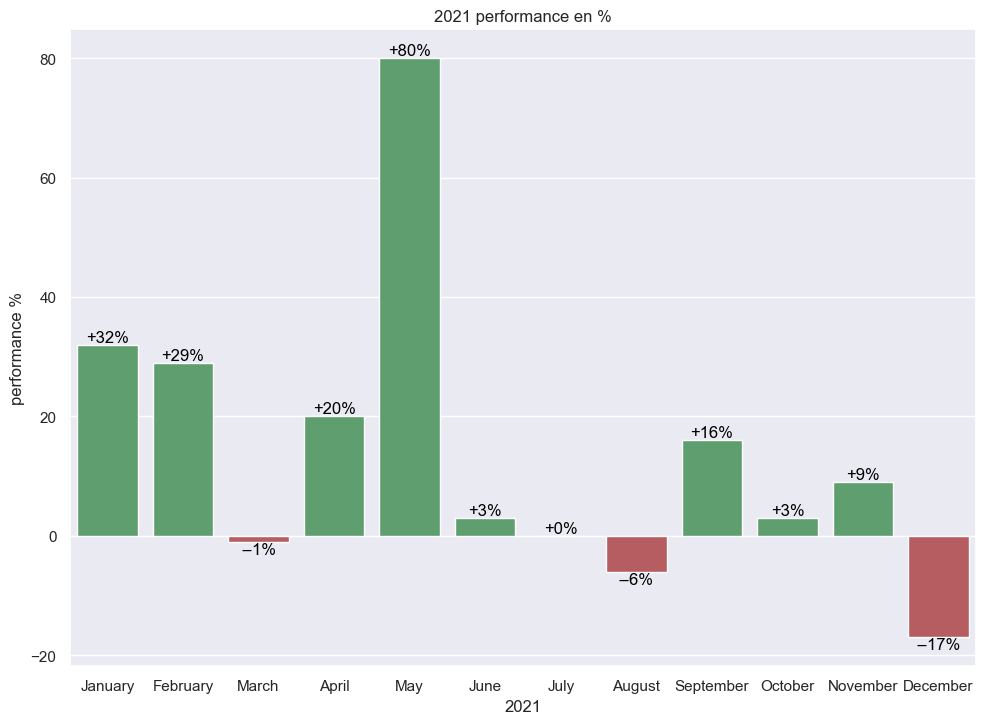

----- 2022 Performances cumulées: 141.28% --


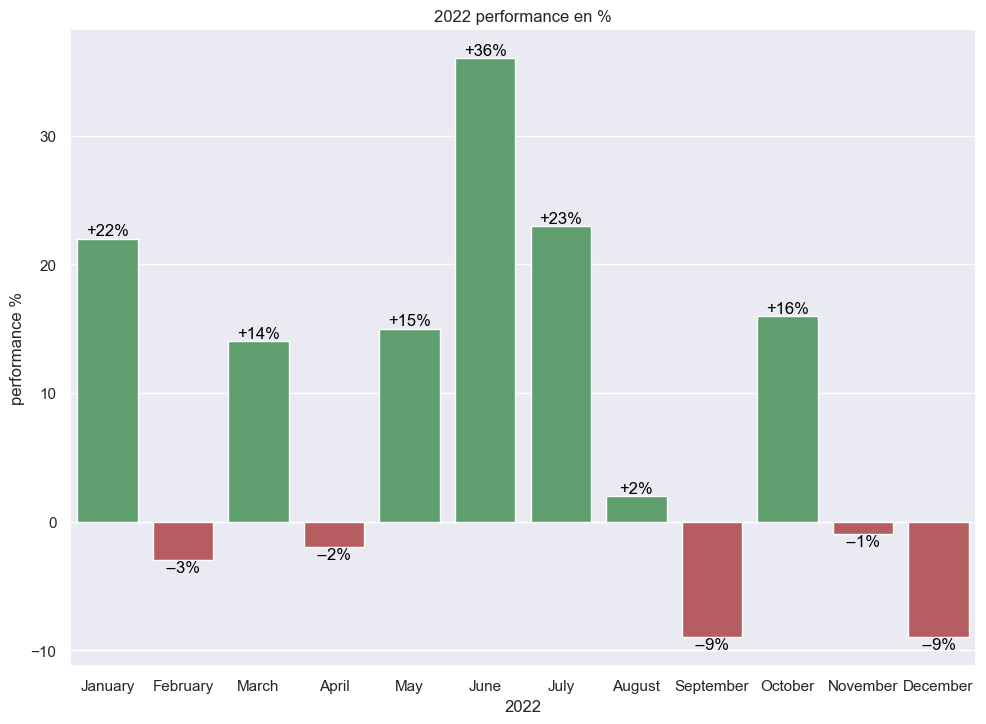

----- 2023 Performances cumulées: 27.62% --


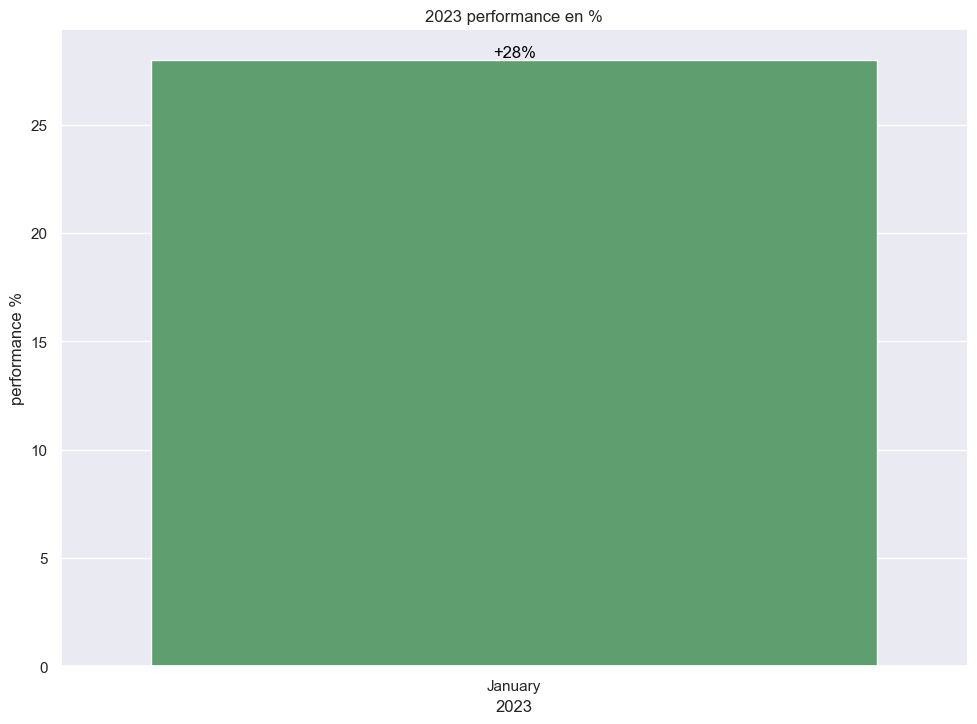

In [36]:
plot_bar_by_month(df_days=df_days)

In [41]:
# Optimisation des paramètres de la stratégie bol_trend sur le sharpe ratio et le win rate
from math import ceil
from IPython.display import clear_output
import time
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

dt = None
dt = pd.DataFrame(columns = ['bol_window', 'bol_std', 'long_ma', 'short_ma', 'sharpe_ratio', 'win_rate'])

#bol window
# loopI = [30,115,5]        #Standard
# loopI = [250,200,20]       #Recherche large
loopI = [40,160,10]       #Recherche fine
# loopI = [20,30,5]         #Pour test rapide
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

#bol std
# loopJ = [10,35,5]         #Standard
# loopJ = [10,45,10]        #Recherche large
loopJ = [10,30,5]        #Recherche fine
# loopJ = [10,15,5]         #Pour test rapide
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

#long ma
# loopK = [300,800,50]      #Standard
# loopK = [50,1000,100]     #Recherche large
loopK = [200,900,50]    #Recherche fine
# loopK = [300,400,50]      #Pour test rapide
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

#short ma
# loopL = [70,140,10]     #Standard
# loopL = [20,140,20]     #Recherche large
loopL = [80,120,10]     #Recherche fine
# loopL = [90,100,5]     #Pour test rapide
enumL = ceil((loopL[1] - loopL[0]) / loopL[2])

count = 0
maxCount = enumI * enumJ * enumK * enumL
for i in range(loopI[0], loopI[1], loopI[2]):
    for j in range(loopJ[0], loopJ[1], loopJ[2]):
         for k in range(loopK[0], loopK[1], loopK[2]):
             for l in range(loopL[0], loopL[1], loopL[2]):
                new_bol_std=j/10
                clear_output(wait=True)
                count += 1
                print("Loading...",count,'/',maxCount)
                print(i, new_bol_std, k)

                # Paramètres à modifier pour la stratégie
                strat = BolTrend(
                    df = df.loc["2020":],
                    type=["long","short"],
                    bol_window = i,
                    bol_std = new_bol_std,
                    min_bol_spread = 0,
                    long_ma_window = k,
                    short_ma_window = l,
                )

                strat.populate_indicators()
                strat.populate_buy_sell()
                bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
                myrow = {'bol_window': i, 'bol_std': new_bol_std, 'long_ma': k, 'short_ma': l, 'sharpe_ratio': bt_result['sharpe_ratio'], 'win_rate': bt_result['win_rate']*100}
                myrow = pd.DataFrame(myrow, index=[0])
                dt = pd.concat([dt, myrow], ignore_index=True)   

dt = dt.sort_values(by=['sharpe_ratio','win_rate'], ascending=False)
# fileName = "optimize/optimizer_ETH_1h_v2_large.csv"
fileName = "optimize/optimizer_ETH_1h_v2_fine.csv"
print("Sauvegarde dans le fichier " + fileName)
dt.to_csv(fileName, index=False)

Loading... 2688 / 2688
150 2.5 850
Sauvegarde dans le fichier optimize/optimizer_ETH_1h_v2_fine.csv


In [65]:
# Visualisation 3D des paramètres
import plotly.graph_objects as go

dt_3d=pd.read_csv("optimize/optimizer_ETH_1h_v2_fine.csv")

# Echantillon à garder
quantile = 0.9

# Ne garder que les 30% des valeurs les plus hautes du Sharpe ratio
dt_3d_filtered = dt_3d[dt_3d['sharpe_ratio'] > dt_3d['sharpe_ratio'].quantile(quantile)]
# dt_3d_filtered = dt_3d[dt_3d['win_rate'] > dt_3d['win_rate'].quantile(quantile)]

fig = go.Figure(data=[go.Scatter3d(
    x=dt_3d_filtered['bol_window'], 
    y=dt_3d_filtered['bol_std'], 
    z=dt_3d_filtered['long_ma'], 
    mode='markers',
    marker=dict(size=dt_3d_filtered['win_rate'], sizemode='diameter', sizeref=1,
                color=dt_3d_filtered['sharpe_ratio'], colorscale='ylorrd', opacity=1,
                colorbar=dict(title='Sharpe Ratio', titleside='right',tickmode='array',
                tickvals=[dt_3d['sharpe_ratio'].min(),dt_3d['sharpe_ratio'].max()], 
                ticktext=[round(dt_3d_filtered['sharpe_ratio'].min(), 4), round(dt_3d_filtered['sharpe_ratio'].max(),4)]))
)])

# Mise en évidence des paramètres les plus hauts
# fig.add_trace(go.Scatter3d(x=[65,65], y=[3,3], z=[dt_3d_filtered['long_ma'].min(), dt_3d_filtered['long_ma'].max()], mode='lines', line=dict(color='red')))

fig.update_layout(
    width=900, height=700,
    title='Visualisation 3D des meilleurs paramètres par rapport au Sharpe Ratio ('+ str(100-(quantile*100)) + '% des valeurs les plus hautes)<br><b>Winrate = taille des bulles',
    scene = dict(
                xaxis_title='Bollinger window',
                yaxis_title='Standard deviation ',
                zaxis_title='MA Long'
                )
)

fig.show()

In [ ]:
# Optimisation des paramètres de la stratégie bol_trend sur le sharpe ratio avec optimize.minimize (inversé pour le max)
import scipy.optimize as optimize
import time
import itertools
from IPython.display import clear_output

def optimize_strategy(parameters):
    # Récupération des paramètres
    bol_window, bol_std, long_ma_window, short_ma_window = parameters

    # Initialisation de la stratégie avec les paramètres
    strat = BolTrend(
        df = df.loc["2020":],
        type=["long","short"],
        bol_window = bol_window,
        bol_std = bol_std,
        min_bol_spread = 0,
        long_ma_window = long_ma_window,
        short_ma_window = short_ma_window,
    )

    # Exécution de la stratégie
    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)

    # Calcul du Sharpe ratio
    sharpe_ratio = bt_result['sharpe_ratio']
    print("bol windows:", bol_window, " bol std: ", bol_std, " long ma: ", long_ma_window, " short ma: ", short_ma_window)
    print("sharpe ratio: ", sharpe_ratio)

    # Inversion du ratio Sharpe pour maximiser la valeur (la fonction minimize minimise la valeur)
    return -sharpe_ratio


# Génération des valeurs initiales des paramètres
""" bol_window_values = np.linspace(20, 70, 11)
bol_std_values = np.linspace(1.0, 3.5, 6)
long_ma_window_values = np.linspace(200, 800, 13)
short_ma_window_values = np.linspace(90, 110, 3) """

# Pour test rapide
bol_window_values = np.linspace(20, 40, 2)
bol_std_values = np.linspace(2.0, 2.5, 2)
long_ma_window_values = np.linspace(400, 450, 2)
short_ma_window_values = np.linspace(100, 105, 1)

maxCount = len(bol_window_values) * len(bol_std_values) * len(long_ma_window_values) * len(short_ma_window_values)

# Exécution de l'optimisation pour chaque combinaison de valeurs initiales
results = []
count = 0

# Début du chronomètre
start_time = time.time()
for bol_window, bol_std, long_ma_window, short_ma_window in itertools.product(bol_window_values, bol_std_values, long_ma_window_values, short_ma_window_values):
    x0 = [bol_window, bol_std, long_ma_window, short_ma_window]
    bounds = [(bol_window, bol_window), 
              (bol_std, bol_std),
              (long_ma_window, long_ma_window),
              (short_ma_window, short_ma_window)]
    count += 1
    print("Loading...",count,'/',maxCount)
    clear_output(wait=True)
    
    result = optimize.minimize(optimize_strategy, x0, bounds=bounds, method='L-BFGS-B')
    results.append(result)
end_time = time.time()
print(f"Temps d'exécution : {end_time - start_time:.2f} secondes")

# Récupération des meilleurs paramètres
best_result = min(results, key=lambda x: x.fun)
bol_window, bol_std, long_ma_window, short_ma_window = best_result.x
print(f"""------------------------------------------
Les meilleurs paramètres sont: 
      \033[32mbol_window=\033[1m{bol_window}\033[0m, \033[32mbol_std=\033[1m{bol_std}\033[0m, \033[32mlong_ma_window=\033[1m{long_ma_window}\033[0m, \033[32mshort_ma_window=\033[1m{short_ma_window}\033[0m 
      avec \033[32msharpe ratio:\033[1m{round(-best_result.fun,4)}""")


bol windows: 40.0  bol std:  2.5  long ma:  450.0  short ma:  100.0
sharpe ratio:  2.073361231749881
Temps d'exécution : 9.31 secondes
------------------------------------------
Les meilleurs paramètres sont: 
      bol_window=40.0, bol_std=2.0, long_ma_window=450.0, short_ma_window=100.0 
      avec sharpe ratio:2.0734
